# Evaluate different architectures of the autoencoder  

Notebook Author: Aniket Tekawade, Argonne National Laboratory, atekawade@anl.gov  

This notebook will run some tests on a different trained encoder-decoder architectures to (1) visualize the latent space clusters from the encoder (2) evaluate segmentation accuracy of the encoder-decoder.

### Set paths and arguments  

In [1]:
from tensorflow.config.experimental import *
GPU_mem_limit = 16.0
gpus = list_physical_devices('GPU')
if gpus:
  try:
    set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])
  except RuntimeError as e:
    print(e)        

In [2]:
# paths
model_path = "/data02/MyArchive/aisteer_3Dencoders/models"
csv_path = "/data02/MyArchive/aisteer_3Dencoders/data_TomoTwin/datalist_train.csv"

# arguments
n_samples = 5000
noise_level = 0.18
patch_size = tuple([64]*3)
binning = 2

model_tags = ["110d32_set6", "111d32_set6", "110d16_set6", "111d16_set6", "110d8_set6", "111d8_set6"]
nmodels = len(model_tags)

In [3]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import h5py
import time

import matplotlib.pyplot as plt
import matplotlib as mpl

from tomo_encoders.img_stats import Parallelize, calc_jac_acc
from tomo_encoders.data_sampling import data_generator_4D, get_data_from_flist
from tomo_encoders.porosity_encoders import custom_objects_dict
from tomo_encoders.latent_vis import *

from tensorflow.keras.models import load_model
import pickle

figw = 8
import seaborn as sns
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
import time

### Load the data and draw $64^3$ sized samples

In [4]:
Xs, Ys, plot_labels = get_data_from_flist(csv_path, \
                                       normalize = True,\
                                       data_tags = ("recon", "gt_labels"),\
                                       group_tags = ["tomo"],\
                                       downres = binning)

dg = data_generator_4D(Xs, Ys, \
                             patch_size, n_samples, \
                             scan_idx = True, add_noise = noise_level)
x, y, sample_labels = next(dg)
print("Shape of x: %s"%str(x.shape))

Shape of x: (5000, 64, 64, 64, 1)


**Histogram of sampled patches:** How many patches are drawn from each dataset?  

<AxesSubplot:ylabel='label'>

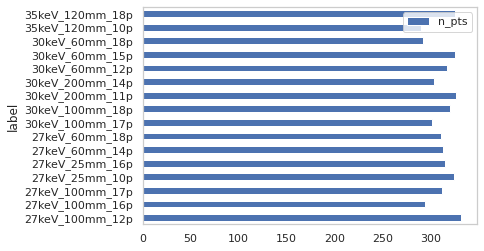

In [5]:
tmp_labels = [plot_label.split('train_blobs_')[-1] for plot_label in plot_labels]

sample_hist = pd.DataFrame(columns = ["label", "n_pts"])
sample_hist["label"] = tmp_labels
sample_hist = sample_hist.set_index("label")

for idx, sample_lab in enumerate(tmp_labels):
    sample_hist.loc[sample_lab, "n_pts"] = np.size(np.where(sample_labels == idx))    
# sample_hist
sample_hist.plot.barh()

### Load Models  

In [6]:
dfs = dict(zip(model_tags, [0]*nmodels))
for idx, model_tag in enumerate(model_tags):
    
    latent_dims = int(model_tag.split('_')[0].split('d')[-1])
    model_names = {"segmenter" : "segmenter%s.hdf5"%model_tag, \
                   "encoder" : "encoder%s.hdf5"%model_tag, \
                   "PCA" : "PCA%s.pkl"%model_tag}

    encoder = load_model(os.path.join(model_path, model_names["encoder"]), \
                         custom_objects = custom_objects_dict)
    
    dfN = get_latent_vector(encoder, x, sample_labels, plot_labels)

    
    pkl_filename = os.path.join(model_path, model_names["PCA"])

    # Load from file
    with open(pkl_filename, 'rb') as file:
        pca = pickle.load(file)
        
    ncomps = 2
    dfs[model_tag] = transform_PCA(dfN, latent_dims, pca, ncomps = ncomps)
    dfs[model_tag]["${||{h}||}$"] = np.linalg.norm(dfN[["$h_%i$"%i for i in range(latent_dims)]], axis = 1)
    
    dfs[model_tag] = rescale_z(dfs[model_tag])
    print('\rdone %i'%idx, end = "")  

done 5

### Compare models / architectures  

**Plot latent space of models**

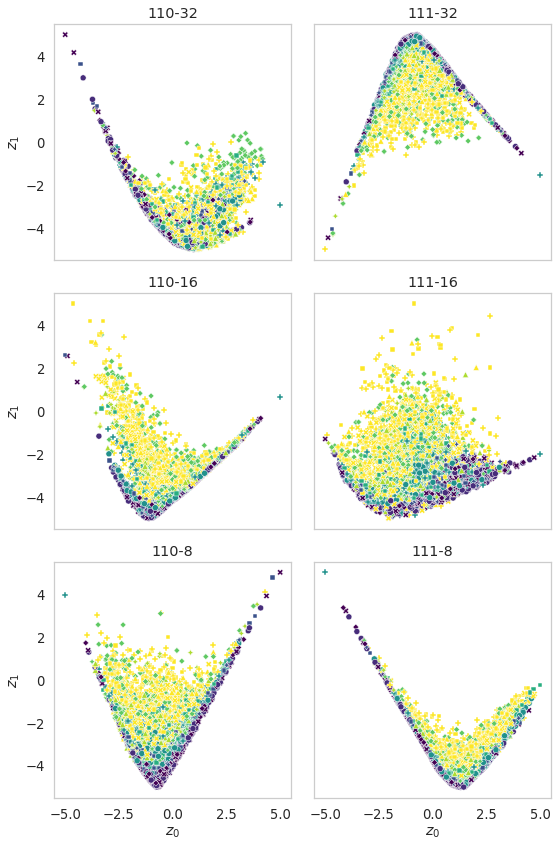

In [7]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(3,2,figsize = (8,12), sharex = True, sharey = True)

for idx, model_tag in enumerate(model_tags):

    sns.scatterplot(data = dfs[model_tag], x = "$z_0$", y = "$z_1$", \
                    hue = "param", \
                    palette = "viridis", ax = ax.flat[idx], \
                    legend = False, \
                    style = "measurement", )
#     ax.flat[idx].set_ylim([-3,4])
#     ax.flat[idx].set_xlim([-8,10])
    modelid = model_tag.split('_')[0].split('d')
    modelid = ('-').join(modelid)
    ax.flat[idx].set_title("%s"%modelid)
    

fig.tight_layout()

**Plot segmentation accuracy** of different models  

In [8]:
for idx, model_tag in enumerate(model_tags):  
    model_names = {"segmenter" : "segmenter%s.hdf5"%model_tag, \
                   "encoder" : "encoder%s.hdf5"%model_tag, \
                   "PCA" : "PCA%s.pkl"%model_tag}

    # encoder.compile()
    segmenter = load_model(os.path.join(model_path, model_names["segmenter"]), \
                         custom_objects = custom_objects_dict)

    yp = segmenter.predict(x)
    yp = np.round(yp)
    mean_IoUs = Parallelize(list(zip(y, yp)), calc_jac_acc, procs = 48)
    dfs[model_tag]["IoU"] = mean_IoUs

#     dfs[model_tag] = pd.concat([dfs[model_tag], df_temp], axis = 1)
    print('\rdone %i'%idx, end = "")  
    

NameError: name 'Pool' is not defined

In [ ]:
modelids = []
IoU_mean = []
for idx, model_tag in enumerate(model_tags):  
    
    modelid = model_tag.split('_')[0].split('d')
    modelid = ('-').join(modelid)
    IoU_mean.append(np.mean(dfs[model_tag]["IoU"]))
    modelids.append(modelid)

model_tag = "111d32_set6"
modelid = model_tag.split('_')[0].split('d')
modelid = ('-').join(modelid)


bins = ["10-12", "12-14", "14-16", "16-18"]
IoU_binned = []
IoU_binned.append(np.mean(dfs[model_tag][dfs[model_tag]["param"].between(10,11,inclusive = True)]["IoU"]))
IoU_binned.append(np.mean(dfs[model_tag][dfs[model_tag]["param"].between(12,13,inclusive = True)]["IoU"]))
IoU_binned.append(np.mean(dfs[model_tag][dfs[model_tag]["param"].between(14,15,inclusive = True)]["IoU"]))
IoU_binned.append(np.mean(dfs[model_tag][dfs[model_tag]["param"].between(16,18,inclusive = True)]["IoU"]))    

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (6,6), sharey = True)
ax[1].bar(modelids, IoU_mean)
ax[1].set_xlabel("model id")
ax[1].set_ylabel("IoU")
ax[0].bar(bins, IoU_binned)
ax[0].set_xlabel("param $s_p$")
ax[0].set_title("(a) binned over $s_p$ for %s"%modelid)
ax[0].set_ylim([0.6,1.0])
ax[1].set_ylim([0.6,1.0])
ax[1].set_title("(b) mean IoU all models")
fig.tight_layout()

In [ ]:
for idx, model_tag in enumerate(model_tags):  
    dfs[model_tag].to_csv(os.path.join('../../model_data/', model_tag + '.csv'))

### THE END